In [1]:
import math
import cmath

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize

# Течение Джеффри-Гамеля

$
f'^2 = (1 - f) \left[ \frac{2}{3} \alpha Re (f^2 + f) + 4 \alpha^2 f + b \right]
$

In [2]:
def df(f, b, alpha, reynolds):
    return -np.sqrt(
        (1 - f) * (2 / 3 * alpha * reynolds * (f**2 + f) + 4 * alpha**2 * f + b)
    )

# Фазовый портрет

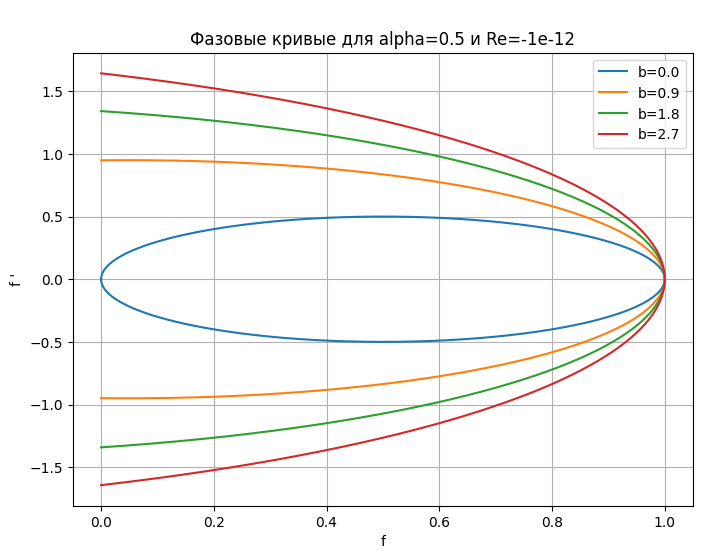

In [3]:
alpha, reynolds = 0.5, -1e-12 

plt.figure(figsize=(8, 6), dpi=100)

for b in np.arange(0, 3, step=0.9):
    x = np.linspace(0, 1, 100_000)
    y = df(x, b, alpha, reynolds)
    
    x = np.concatenate((x, x[-1::-1]))
    y = np.concatenate((y, -y[-1::-1]))
    
    plt.plot(x, y, label=f'b={b}')

plt.title(f"""
Фазовые кривые для alpha={alpha} и Re={reynolds}""")
plt.xlabel('f')
plt.ylabel('f \'')
plt.legend()
plt.grid()

# Решение задачи

In [4]:
class JefferyHamelFlow:
    def __init__(self, alpha, reynolds):
        self.alpha = alpha
        self.reynolds = reynolds
    
    def get_equation(self, b):
        def equation(x, y):
            return df(y, b, self.alpha, self.reynolds)
        
        return equation
    
    def second_app(self, h, b):
        return 1 - h**2 / 2 * (2 / 3 * self.alpha * self.reynolds + 2 * self.alpha**2 + b / 2)
    
    def get_boundary_equation(self, h):
        def f_boundary(b):
            equation = self.get_equation(b)
            f_start = self.second_app(h, b)

            solution = integrate.solve_ivp(equation, 
                                           t_span=[h, 1], y0=[f_start],
                                           first_step=h, method='RK45',
                                           t_eval=np.arange(h, 1, step=h))

            return solution.y[0][-1]
    
        return f_boundary
    
    def calculate(self, cells_num):
        h = (1 - 0) / cells_num
        
        boundary_equation = self.get_boundary_equation(h)
        solution_b = optimize.newton(boundary_equation, 
                                     x0=0, tol=h)

        equation = self.get_equation(solution_b)
        f_start = self.second_app(h, solution_b)

        solution = integrate.solve_ivp(equation,
                                       t_span=[0, 1], y0=[f_start], 
                                       first_step=h, method='RK45', 
                                       t_eval=np.linspace(h, 1, num=cells_num))

        return solution

# Тестирование сходимости численного метода к течению Пуазейля

In [5]:
def poiseuille_flow():
    x = np.linspace(0, 1, num=100000)
    y = np.ones((len(x), )) - x * x
    
    return x, y

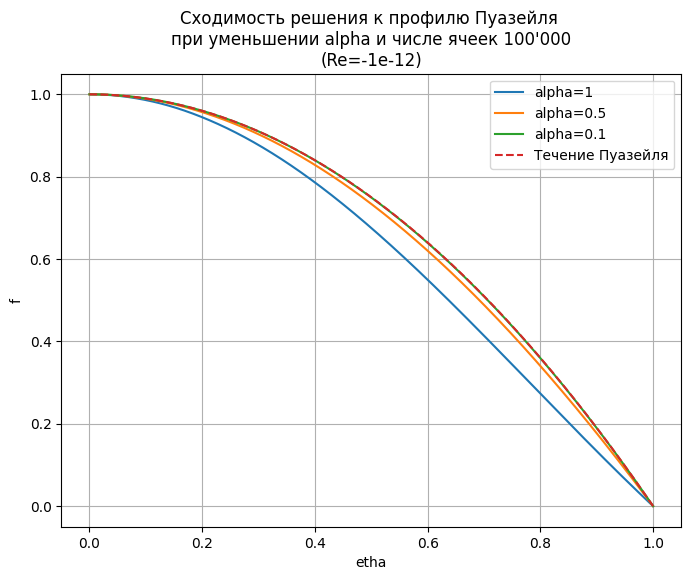

In [6]:
alphas = [
    1,
    0.5,
    1e-1
]
reynolds = -1e-12

plt.figure(figsize=(8, 6), dpi=100)

for alpha in alphas:
    flow = JefferyHamelFlow(alpha, reynolds)
    solution = flow.calculate(100_000)
    
    plt.plot(solution.t, solution.y[0], 
             label=f'alpha={alpha}')
    
x, y = poiseuille_flow()
plt.plot(x, y, 
         label='Течение Пуазейля', 
         ls='--')

plt.title(
f"""Сходимость решения к профилю Пуазейля 
при уменьшении alpha и числе ячеек 100'000
(Re={reynolds})"""
)
plt.xlabel('etha')
plt.ylabel('f')
plt.legend()
plt.grid()

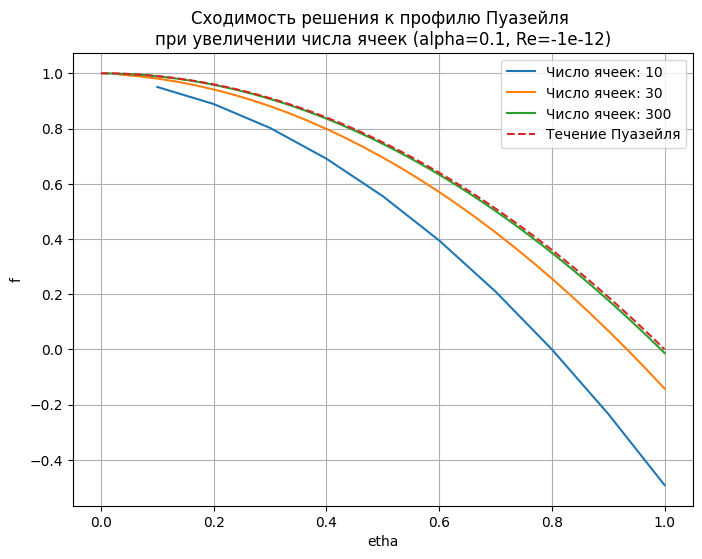

In [7]:
cells_nums = [10, 30, 300]

reynolds = -1e-12
alpha = 0.1

flow = JefferyHamelFlow(alpha, reynolds)

plt.figure(figsize=(8, 6), dpi=100)

for cells_num in cells_nums:
    solution = flow.calculate(cells_num)
    
    plt.plot(solution.t, solution.y[0], 
             label=f'Число ячеек: {cells_num}')
    

x, y = poiseuille_flow()
plt.plot(x, y, 
         label='Течение Пуазейля', 
         ls='--')

plt.title(
f"""Сходимость решения к профилю Пуазейля 
при увеличении числа ячеек (alpha={alpha}, Re={reynolds})"""
)
plt.xlabel('etha')
plt.ylabel('f')
plt.legend()
plt.grid()

# Финальные результаты расчета

<ipython-input-2-74a2c73e469c>:2: RuntimeWarning: invalid value encountered in sqrt
  return -np.sqrt(
<ipython-input-2-74a2c73e469c>:2: RuntimeWarning: invalid value encountered in sqrt
  return -np.sqrt(
<ipython-input-2-74a2c73e469c>:2: RuntimeWarning: invalid value encountered in sqrt
  return -np.sqrt(


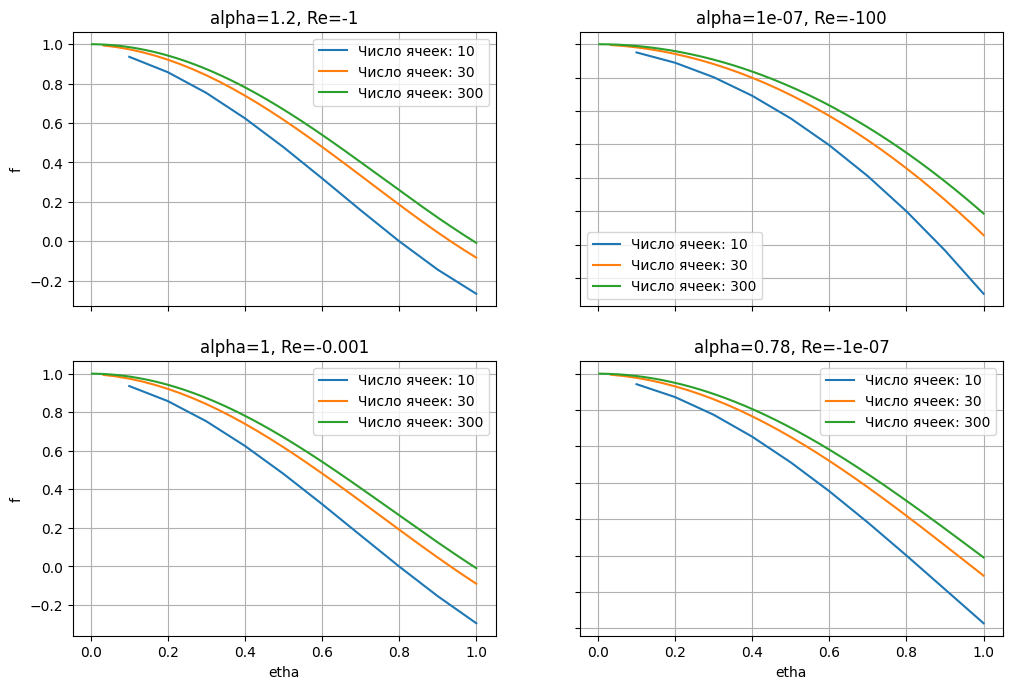

In [8]:
inputs = [
    (1.2, -1),
    (1, -1e-3),
    (1e-7, -100),
    (0.78, -1e-7),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=100)

for index, params in enumerate(inputs):
    flow = JefferyHamelFlow(*params)
    
    i = index % 2
    j = index // 2
    
    axs[i][j].set_title(f'alpha={flow.alpha}, Re={flow.reynolds}')
    for cells_num in [10, 30, 300]:
        solution = flow.calculate(cells_num)
        
        axs[i][j].plot(solution.t, solution.y[0], 
                       label=f'Число ячеек: {cells_num}')
        
for ax in axs.flat:
    ax.set(xlabel='etha', ylabel='f')
    
for ax in axs.flat:
    ax.label_outer()
    ax.legend()
    ax.grid()

<ipython-input-2-74a2c73e469c>:2: RuntimeWarning: invalid value encountered in sqrt
  return -np.sqrt(


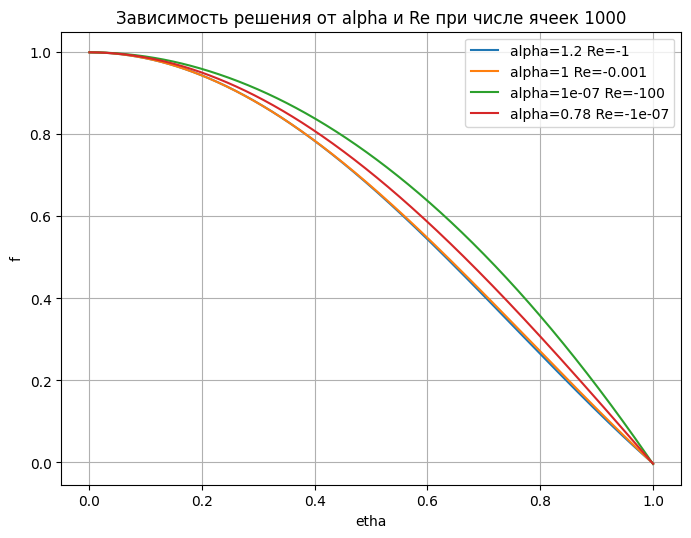

In [9]:
plt.figure(figsize=(8, 6), dpi=100)

for params in inputs:
    flow = JefferyHamelFlow(*params)
    solution = flow.calculate(1000)
    
    plt.plot(solution.t, solution.y[0], 
             label=f'alpha={flow.alpha} Re={flow.reynolds}')
    
plt.legend()
plt.xlabel('etha')
plt.ylabel('f')
plt.title('Зависимость решения от alpha и Re при числе ячеек 1000')
plt.grid()

<ipython-input-2-74a2c73e469c>:2: RuntimeWarning: invalid value encountered in sqrt
  return -np.sqrt(


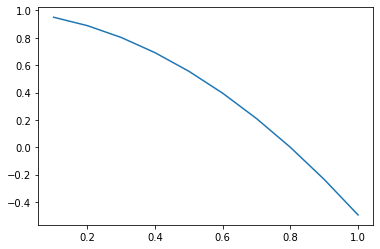

In [26]:
flow = JefferyHamelFlow(alpha=1e-7, reynolds=-100)
solution = flow.calculate(10)

plt.plot(solution.t, solution.y[0])